# Crop the 3D Volume based on some points

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
## To find out the suitable crop size.
## based on ROI points
import Functions.MyDataset as MyDataset
import importlib

importlib.reload(MyDataset)

name_list, pts = MyDataset.load_data_dir("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/")

In [3]:
max_diff_x = 0
max_diff_y = 0
max_diff_z = 0

for patient in range(pts.shape[0]):
    diff_x = max([abs(pts[patient, 0, 0]-pts[patient, 1, 0]), abs(pts[patient, 0, 0]-pts[patient, 2, 0]),
                  abs(pts[patient, 0, 0]-pts[patient, 3, 0])])
    max_diff_x = max([max_diff_x, diff_x])
    diff_y = max([abs(pts[patient, 0, 1]-pts[patient, 1, 1]), abs(pts[patient, 0, 1]-pts[patient, 2, 1]),
                  abs(pts[patient, 0, 1]-pts[patient, 3, 1])])
    max_diff_y = max([max_diff_y, diff_y])
    diff_z = max([abs(pts[patient, 0, 2]-pts[patient, 1, 2]), abs(pts[patient, 0, 2]-pts[patient, 2, 2]),
                  abs(pts[patient, 0, 2]-pts[patient, 3, 2])])
    max_diff_z = max([max_diff_z, diff_z])

In [4]:
print("max_diff_x: ", max_diff_x)
print("max_diff_y: ", max_diff_y)
print("max_diff_z: ", max_diff_z)

max_diff_x:  598.4984170064738
max_diff_y:  188.47062902601624
max_diff_z:  169.4043149939154


## Looks like the area is still too big (598, 188, 169)
So, we think we can focus on the left and right landmark area separately

In [46]:
import numpy as np

def crop(volume, points, crop_size):
    """
    crop_size: ((x_d, x_a), (y_d, y_a), (z_d, z_a))
        x_d is the length from the centre of the given points to the descending direction of axis x
        x_a is the length from the centre of the given points to the ascending direction of axis x
        ...
    """
    fill_value = np.min(volume)
    ((x_d, x_a), (y_d, y_a), (z_d, z_a)) = crop_size
    # initialize the cropped_volume with the minimal value in the volume
    cropped_volume = np.ones((x_d+x_a, y_d+y_a, z_d+z_a)) * fill_value

    centre = np.average(points, axis=0).astype(int)

    # find the border on axis x
    x_start = 0
    x_idx_min = centre[0] - x_d
    x_length = x_d + x_a
    if x_idx_min < 0:
        x_length = x_length - abs(x_idx_min)
        x_start = abs(x_idx_min)
        x_idx_min = 0
    x_idx_max = centre[0] + x_a
    if x_idx_max > (volume.shape[0]-1):
        x_length = x_length - (x_idx_max - (volume.shape[0] - 1))
        x_idx_max = volume.shape[0] - 1

    # find the border on axis y
    y_start = 0
    y_idx_min = centre[1] - y_d
    y_length = y_d + y_a
    if y_idx_min < 0:
        y_length = y_length - abs(y_idx_min)
        y_start = abs(y_idx_min)
        y_idx_min = 0
    y_idx_max = centre[1] + y_a
    if y_idx_max > (volume.shape[1]-1):
        y_length = y_length - (y_idx_max - (volume.shape[1] - 1))
        y_idx_max = volume.shape[1] - 1

    # find the border on axis z
    z_start = 0
    z_idx_min = centre[2] - z_d
    z_length = z_d + z_a
    if z_idx_min < 0:
        z_length = z_length - abs(z_idx_min)
        z_start = abs(z_idx_min)
        z_idx_min = 0
    z_idx_max = centre[2] + z_a
    if z_idx_max > (volume.shape[2]-1):
        z_length = z_length - (z_idx_max - (volume.shape[2] - 1))
        z_idx_max = volume.shape[2] - 1

    # crop the volume
    cropped_volume[x_start:(x_start+x_length), y_start:(y_start+y_length), z_start:(z_start+z_length)] = \
        volume[x_idx_min:(x_idx_min+x_length), y_idx_min:(y_idx_min+y_length), z_idx_min:(z_idx_min+z_length)]
    # relocate the points
    cropped_points =  points - np.ones(points.shape) * np.array([x_idx_min, y_idx_min, z_idx_min]) + \
                     np.ones(points.shape) * np.array([x_start, y_start, z_start])

    return cropped_volume, cropped_points

def crop_volume(volume, points):
    """
    Crop the landmark areas for left and right ears separately
    The outputs are two cubic volume 100*100*100 (may change in the future).
    Input:  1. Volume: the original volume
            2. Points: LLSCC ant/post, RLSCC ant/post

    Output: 1. (left_area_volume, landmark_points)
            2. (right_area_volume, landmark_points)
    """
    crop_size = ((50, 50), (50, 50), (50, 50))
    # points coordinate is (x, y, z), swap to (y, x, z) to cooperate the volume (row, clown, slice)
    points = points[:, [1, 0, 2]]
    left_area, left_landmarks = crop(volume, points[0:2], crop_size)
    left_landmarks = left_landmarks[:, [1, 0, 2]]
    right_area, right_landmarks = crop(volume, points[2:4], crop_size)
    right_landmarks = right_landmarks[:, [1, 0, 2]]
    flip_right_area = np.fliplr(right_area)
    flip_right_landmarks = np.copy(right_landmarks)
    flip_right_landmarks[:, [0]] = \
        np.ones(flip_right_landmarks[:, [0]].shape) * (crop_size[0][0] + crop_size[0][1] - 1) - flip_right_landmarks[:, [0]]

    return left_area, left_landmarks, flip_right_area, flip_right_landmarks

In [ ]:
## Check the cropped results

import importlib
import Functions.MyDataset as MyDataset
import Functions.Visualization as Visualization

JH_aug_mat_path = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/AH_aug_1.mat"
# JH_reshape_vol_mat_path = "/Volumes/Shawn_SSD/PhD/Project/Date/augmentation_from_matlab/Val/Input/FA_17017030_AugVol_2.mat"
# JH_reshape_pts_mat_path = "/Volumes/Shawn_SSD/PhD/Project/Date/augmentation_from_matlab/Val/Output/FA_17017030_AugPts_2.mat"

pixel_space = [0.15, 0.15, 0.15]

importlib.reload(MyDataset)

JH_aug_volume, JH_aug_pts, _ = MyDataset.load_mat_data(JH_aug_mat_path)

# JH_aug_zoomed_volume, JH_aug_zoomed_pts = MyDataset.load_mat_data(JH_reshape_vol_mat_path, JH_reshape_pts_mat_path)
Visualization.show_pts(JH_aug_volume, JH_aug_pts, pixel_space)

In [51]:
left_volume, left_points, flip_right_volume, flip_right_points = crop_volume(JH_aug_volume, JH_aug_pts)

In [48]:
print("left_points: ", left_points)
print("flip_right_points: ", flip_right_points)

left_points:  [[54. 36. 51.]
 [47. 65. 49.]]
flip_right_points:  [[55. 37. 53.]
 [42. 64. 47.]]


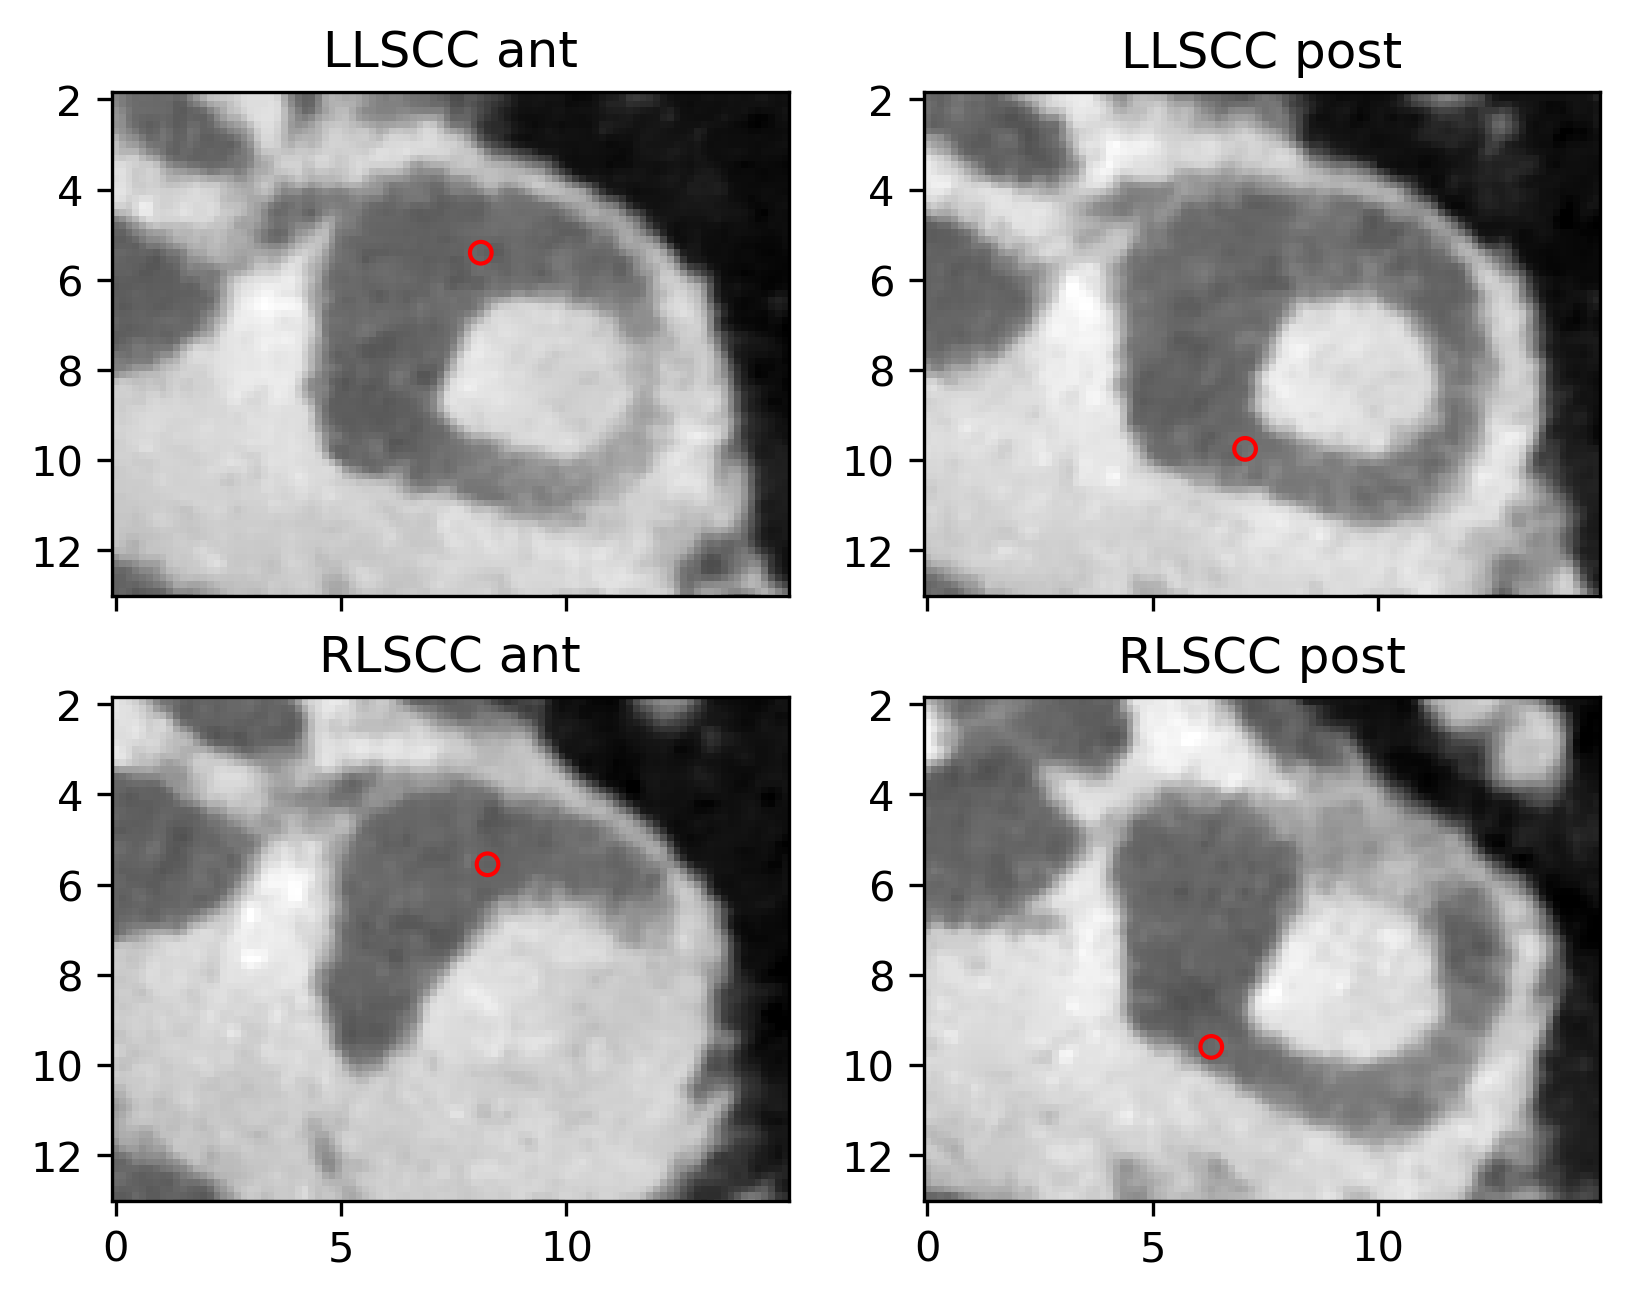

In [52]:
importlib.reload(Visualization)
import time
from IPython.display import display, clear_output

pixel_space = [0.15, 0.15, 0.15]

Visualization.show_two_landmarks(left_volume, left_points, flip_right_volume, flip_right_points, pixel_space)

# for i in range(100):
#     left_points[0][2] = i
#     left_points[1][2] = i
#     flip_right_points[0][2] = i
#     flip_right_points[1][2] = i
#     Visualization.show_two_landmarks(left_volume, left_points, flip_right_volume, flip_right_points, pixel_space)
#     time.sleep(1)
#     clear_output(wait=True)

## Visualize the Prediction Results